./data/train_data/input/X51005442376.jpg


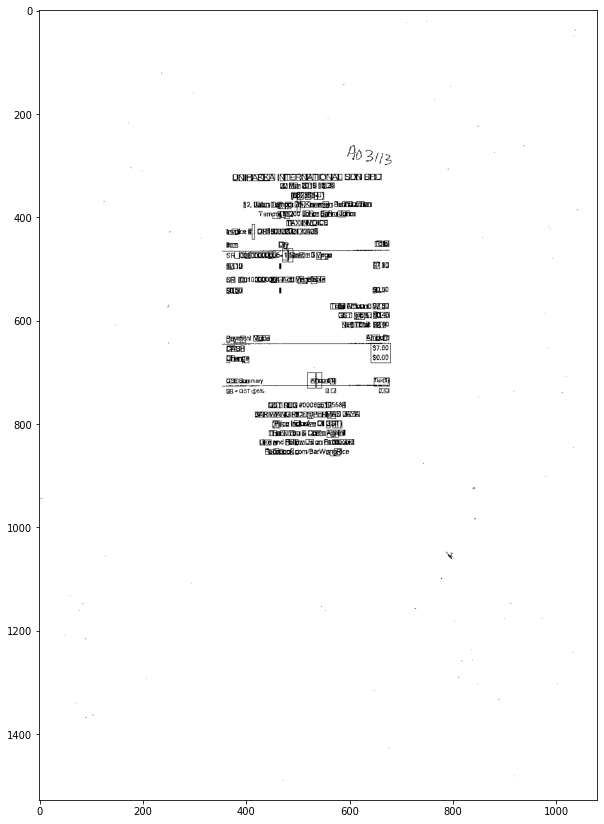

In [246]:
import pytesseract as pt
from matplotlib import pyplot as plt
import os
import cv2
import pandas as pd


image_folder = "./data/train_data/input"
ground_truth_bb = "./data/train_data/ground_truth"
tesseract_path = "/opt/local/bin/tesseract"
ground_truth_classes = "./data/train_data/classes"


pt.pytesseract.tesseract_cmd = tesseract_path


for image in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image)
    print(image_path)
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    enhanced_grayscale_image =  cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)[1]
    extracted_data = pt.image_to_data(enhanced_grayscale_image, output_type=pt.Output.DATAFRAME)
    
#     plt.figure(figsize=(10, 20))
#     plt.imshow(gray, cmap='gray')
#     plt.figure(figsize=(10, 20))
#     plt.imshow(enhanced_grayscale_image, cmap='gray')
#     print(extracted_data["conf"].mean())

    extracted_data = extracted_data[extracted_data["conf"]>10]
    extracted_data["text"] = extracted_data["text"].astype("str")
    extracted_data = extracted_data.reset_index()
    break

    
    

joined_strings = []
for text in extracted_data["text"]:
    if text == " ":
        text = text.replace(" ", "-")
    joined_strings.extend(list(text))

boxes = pt.image_to_boxes(enhanced_grayscale_image)
ttl = 0
start_pixels = list(extracted_data["left"])
count = 0
H, W = enhanced_grayscale_image.shape
rows = dict()
for i in boxes.splitlines():
    char, x, y, w, h, _ = i.split(' ')
    x, y, w, h = int(x), int(y), int(w), int(h)
    if ttl == 0 and x in start_pixels:
        ttl = len(list(extracted_data[extracted_data["left"] == x]["text"])[0])
    if ttl > 0:
        cv2.rectangle(enhanced_grayscale_image, (x, H-y), (w, H-h), (0,0,255), 1)
        row = {"char": char,
              "x": x,
              "y": H-y,
              "w":w,
              "h":H-h,
              "unicode": ord(char)}
        rows[str(count)] = row
        ttl -= 1
        count+= 1


plt.figure(figsize=(10, 20))
plt.imshow(enhanced_grayscale_image, cmap='gray')
    
# print(len(joined_strings), count)

char_grids = pd.DataFrame.from_dict(rows, orient='index')
char_grids = char_grids.loc[(char_grids["unicode"] >= 33) & (char_grids["unicode"] <= 126)]

In [249]:
def convert_to_int(df):
    for i in range(0,7):
        df[i] = df[i].astype("int")
    return df
        
for file_handle in os.listdir(ground_truth_bb):
    if file_handle ==  "X51005442376.txt":
        with open(ground_truth_bb + "/" + file_handle) as file:
            objects = file.read().splitlines()
            
df = pd.DataFrame(objects, columns =['ground_truth'])
df = df["ground_truth"].str.split(',', 8, expand=True)
df = convert_to_int(df)
df = df.rename(columns= {0: "tl_x", 1: "tl_y", 2: "tr_x", 3: "tr_y", 4: "br_x", 5: "br_y", 6: "bl_x", 7: "bl_y",8: "text" })

In [256]:
import json

for file_handle in os.listdir(ground_truth_classes):
    if file_handle ==  "X51005442376.txt":
        with open(ground_truth_classes + "/" + file_handle) as file:
            class_objects = json.load(file)